<a href="https://colab.research.google.com/github/NDBao08/ThucHanh02/blob/master/HMMKalmanFilter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
a = (2251262580%15+1)
a

1

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(r"/content/EW-MAX.csv")
df.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2000/3/27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,2000/3/28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,2000/3/29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,2000/3/30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,2000/3/31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Tính log return từ cột Adj_Close
df['LogReturn'] = np.log(df['Adj_Close'] / df['Adj_Close'].shift(1))
df = df.dropna().reset_index(drop=True)


df[['Date', 'Adj_Close', 'LogReturn']].head()


,Date,Adj_Close,LogReturn
0,2000-03-28,4.015625,-0.026873
1,2000-03-29,4.000000,-0.003899
2,2000-03-30,3.843750,-0.039846
3,2000-03-31,3.390625,-0.125434
4,2000-04-03,3.437500,0.013730


In [9]:
!pip install hmmlearn
from hmmlearn.hmm import GaussianHMM

# Lấy chuỗi log-return làm input
observations = df[['LogReturn']].values  # dạng (n_samples, 1)

# Tạo mô hình HMM với 2 trạng thái
hmm_model = GaussianHMM(n_components=2, covariance_type="full", n_iter=100, random_state=42)

# Huấn luyện mô hình
hmm_model.fit(observations)

# Dự đoán chuỗi trạng thái ẩn
hidden_states = hmm_model.predict(observations)

# Gắn lại vào DataFrame
df['HiddenState'] = hidden_states

# Đếm số lượng mỗi trạng thái
print(df['HiddenState'].value_counts())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 3.5 MB/s eta 0:00:00
HiddenState
0    3868
1     523
Name: count, dtype: int64


In [12]:
!pip install pykalman
from pykalman import KalmanFilter

# Tạo dict để lưu KalmanFilter theo trạng thái
kalman_models = {}
smoothed_states = []

for state in range(2):
    # Lọc dữ liệu theo trạng thái
    mask = df['HiddenState'] == state
    series = df.loc[mask, 'LogReturn'].values.reshape(-1, 1)

    # Khởi tạo Kalman Filter
    kf = KalmanFilter(
        transition_matrices=[1],           # x_t = x_{t-1}
        observation_matrices=[1],          # y_t = x_t
        initial_state_mean=0,
        initial_state_covariance=1,
        observation_covariance=1e-2,       # R
        transition_covariance=1e-4         # Q
    )

    # Huấn luyện và làm trơn
    kf = kf.em(series, n_iter=10)
    smoothed, _ = kf.smooth(series)

    # Lưu mô hình và kết quả
    kalman_models[state] = kf
    smoothed_states.append((mask, smoothed))

# Gắn kết quả smoothed vào DataFrame gốc
df['KalmanSmoothed'] = np.nan
for mask, smoothed in smoothed_states:
    df.loc[mask, 'KalmanSmoothed'] = smoothed.flatten()


In [13]:
# Dự báo giá
last_state = df['HiddenState'].iloc[-1]
last_smoothed = df['KalmanSmoothed'].iloc[-1]
next_log_return_estimate, _ = kalman_models[last_state].filter_update(
    filtered_state_mean=last_smoothed,
    filtered_state_covariance=1,
    observation=None
)

last_price = df['Adj_Close'].iloc[-1]
forecast_price = last_price * np.exp(next_log_return_estimate)

print(f"Dự báo giá tiếp theo: {float(forecast_price[0]):,.2f}")

Dự báo giá tiếp theo: 113.45


<ipython-input-13-fbbef0149815>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Dự báo giá tiếp theo: {float(forecast_price[0]):,.2f}")


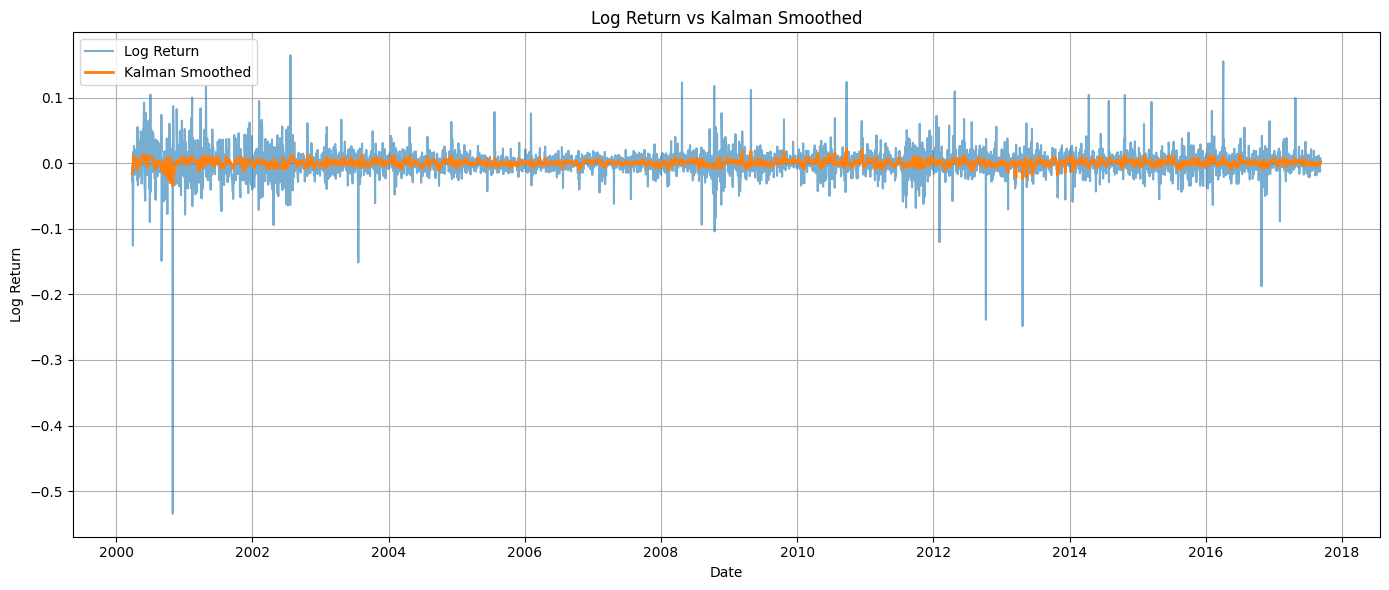

In [14]:
# Vẽ biểu đồ
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['LogReturn'], label='Log Return', alpha=0.6)
plt.plot(df['Date'], df['KalmanSmoothed'], label='Kalman Smoothed', linewidth=2)
plt.title('Log Return vs Kalman Smoothed')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
price_smoothed = [df['Adj_Close'].iloc[0]]
for r in df['KalmanSmoothed'].iloc[1:]:
    price_smoothed.append(price_smoothed[-1] * np.exp(r))
df['PriceKalman'] = price_smoothed

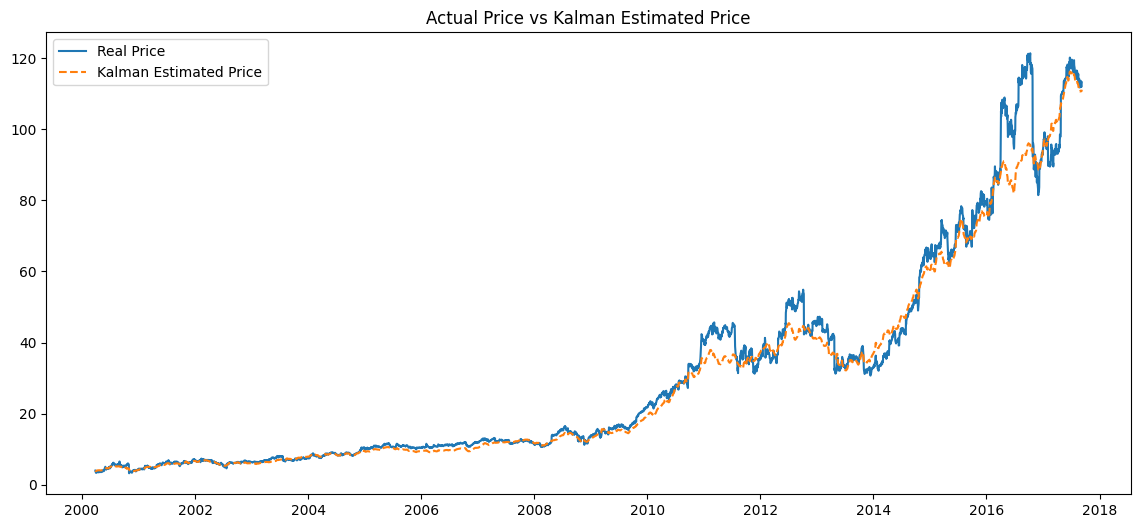

In [16]:
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Adj_Close'], label='Real Price')
plt.plot(df['Date'], df['PriceKalman'], label='Kalman Estimated Price', linestyle='--')
plt.legend()
plt.title('Actual Price vs Kalman Estimated Price')
plt.show()